## CS-E4820 Machine Learning: Advanced Probabilistic Methods (Spring 2023)

Pekka Marttinen, Vishnu Raj, Antti Pöllänen, Nikitin Alexander, Sebastiaan De Peuter, Tommi Gröhn, Julien Martinelli, Ali Khoshvishkaie, Onur Poyraz


## Exercise 9, due on Sunday April 9 at 23:50.

# SVI for linear regression using PyTorch

In this exercise, we will see how to use stochastic variational inference (especially the pathwise estimator) to solve linear regression problem using autograd in PyTorch.

### Bayesian Linear Regression
The model is defined as follows: 
\begin{align*}
y_i &  \sim \mathcal{N}(w_0 + w_1x_i, \sigma_l^2), \quad x_i \in \mathbb{R}, \sigma_l=0.4, i=1,\ldots,N\\
\mathbf{w} &  \sim\mathcal{N}(0, \alpha^2I).
\end{align*}
Note: The data noise is large because the true model used to generate the data is more complex to which we are going to fit a linear model. 

Given data $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^{N}$, we are interested in the posterior distribution $p(\mathbf{w}|\mathcal{D})$ which we approximate using  mean-field approximation: $$ p(\mathbf{w}|\mathcal{D}) \approx q(\mathbf{w}) = \prod_{d=0}^1 q(w_d) = \prod_{d=0}^1 \mathcal{N}(w_d | \mu_d,\sigma_d^2)$$
That is, we model each $w_d$ as an independent Gaussian with mean $\mu_d$ and $\sigma_d^2$ and use SVI to optimize them such that: 

\begin{align}
\hat{\lambda} & = \text{argmin}_{\lambda}\text{KL}[q(\mathbf{w})|p(\mathbf{w} | \mathcal{D})] \\
&= \text{argmin}_{\lambda} \underbrace{\mathbb{E}_{q_{\lambda}(\mathbf{w})}\left[-\log p(\mathcal{D}|\mathbf{w})\right] + \text{KL}\left[q(\mathbf{w})| p(\mathbf{w})\right]}_{Loss = - ELBO}+c. 
\end{align}
Here, the variational parameters are denotd by $\lambda = \{ (\mu_d, \sigma_d), i = 0, 1 \}$. The first term of the ELBO is the expected log likelihood, which will be estimated using pathwise estimator and the second term is the KL between the approximate posterior $q_{\lambda}(\mathbf{w})$ and the prior $p(\mathbf{w})$ that can be derived analytically in this case. 
We will solve this problem in three steps given as three problem below. In the first two problems we derive the two terms of the Loss which, in problem 3 are implemented using the pathwise estimator in PyTorch. 

# Problem 1: Negative log-likelihood
Write the negative log-likelihood (whose expectation is the first term in the Loss) as a scaled mean squared error. 




Write your answer to Problem 1 here.

\begin{align*}
-\log p(\mathcal{D}|\mathbf{w})&=-\sum_{i=1}^N \log \mathcal{N}(y_i\mid\omega_0+\omega_1 x_i, \sigma_l^2)\\
&=-\sum_{i=1}^N-\frac{1}{2}\log(2\pi\sigma_l^2) - \frac{1}{2\sigma_l^2}(y_i - (w_0 + w_1x_i))^2.\\
&\approx \frac{1}{2\sigma_l^2}\sum_{i=1}^N (y_i - (w_0 + w_1x_i))^2.\\
\end{align*}

# Problem 2: Derive KL Divergence 

Derive the analytic solution of $\text{KL}[q_{\lambda}(\mathbf{w})|p(\mathbf{w})]$. This will be required in Problem 3.

__Hint:__ Given $\mathbf{w}$ is a MVN with diagonal covarience and the mean-field approximation of $q_{\lambda}(\mathbf{w})$, the KL divergence for both the components of $\mathbf{w} = (w_0, w_1)$ will have the same form. So this reduces to deriving the KL between two univariate Guassians.



Write your answer to Problem 2 here.

\begin{align*}
\because\text{KL}[q(x) || p(x)] &= \int q(x) \log \frac{q(x)}{p(x)} dx.\\
&= \int \mathcal{N}(x | \mu_q, \sigma_q^2) \log \frac{\mathcal{N}(x | \mu_q, \sigma_q^2)}{\mathcal{N}(x | \mu_p, \sigma_p^2)} dx.\\
&=\frac{1}{2} \left[\log \frac{\sigma_p^2}{\sigma_q^2} - 1 + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{\sigma_p^2}\right]\\
\therefore\text{KL}[q(w_0) || p(w_0)] &= \frac{1}{2} \left[ \log \frac{\alpha^2}{\sigma_0^2} - 1 + \frac{\sigma_0^2 + \mu_0^2}{\alpha^2} \right] = 
\frac{\sigma_0^2 + \mu_0^2}{2\alpha^2} + \log \frac{\alpha}{\sigma_0} - 0.5\\
\text{KL}[q(w_1) || p(w_1)] &= \frac{1}{2} \left[ \log \frac{\alpha^2}{\sigma_1^2} - 1 + \frac{\sigma_1^2 + \mu_1^2}{\alpha^2} \right] =
\frac{\sigma_1^2 + \mu_1^2}{2\alpha^2} + \log \frac{\alpha}{\sigma_1} - 0.5\\
\text{KL}[q_\lambda(\mathbf{w}) || p(\mathbf{w})] &= \text{KL}[q(w_0) || p(w_0)] + \text{KL}[q(w_1) || p(w_1)].\\
\end{align*}

# Problem 3: Pathwise Estimator in PyTorch
Complete the code template below that implements the pathwise estimator.

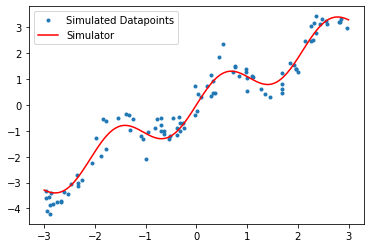

In [5]:
# Starter code for problem 3
# We first simulate the data using following simulator to generate our training and test data: 
# $y_i=x_i+0.7\sin(3x_i)+\epsilon,$ where $\epsilon\sim\mathcal{N}(0,0.16)$
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# We define a function to generate the data according to the simulator
def data_generation(num_data, interval):
    x = np.random.rand(num_data,1) * (interval[1] - interval[0]) + interval[0]
    e = np.random.randn(num_data,1) * 0.4
    y =  x + 0.7 * np.sin(3 * x) + e
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

# Generate the 100 data points with x in [-3, 3] for training, validation, and test dataset.
interval = [-3,3]
num_data = 100
x_train, y_train = data_generation(num_data, interval)
x_val, y_val = data_generation(num_data, interval)
x_test, y_test = data_generation(num_data, interval)
# Visulize the data
fig, ax = plt.subplots()
x_plot = torch.linspace(-3., 3., 1000)
y_plot = x_plot + 0.7 * torch.sin(3 * x_plot)
ax.plot(x_train, y_train, '.')
ax.plot(x_plot, y_plot, '-', color='red')

ax.legend(('Simulated Datapoints','Simulator'))

In [6]:
# template for problem 3
# We define a multivariate Bayesian linear regression model, which has input_dim features and output_dim outputs
class linear_regression(nn.Module):
    def __init__(self, input_dim, output_dim, sigma = 1.):
        super(linear_regression, self).__init__()
        
        # Define the input and output dimension of the LR model
        # In this example, input_dim and output_dim are both 1;
        # They can be other integers when this class is used as the Bayesian neural network layers 
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # set standard deviation of the prior (the $\sigma_w$)
        self.sigma = sigma
        
        scale = 1. * np.sqrt(6. / (input_dim + output_dim))        
        # EXERCISE: Initialize the approximated posterior distribution over the weight and bias terms
        # (i.e. specify values for the corresponding variational parameters).
        # All the weights are assumed independent from each other.
        # Initialize the mean parameters from a uniform distribution over (-scale, scale) to improve stability.
        # Instead of parametrizing the standard deviation sigma directly, we parametrize it using rho:
        # sigma = log(1 + exp(rho)) to keep it positive during training.
        # This way we don't need to use a positivity constraint during optimization.
        
        self.mu_bias = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-scale, scale)) # given as example
        # self.rho_bias = ?
        # self.mu_weights = ?
        # self.rho_weights = ?
        
        # YOUR CODE HERE
        self.rho_bias = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -2))
        # size(self.output_dim)
        
        self.mu_weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-scale, scale))
        # size(self.input_dim, self.output_dim)
        
        self.rho_weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-4, -2))
        # size(self.input_dim, self.output_dim)
        
        # raise NotImplementedError()
        
    def forward(self, x, stochastic_flag):
        eps = 1e-7 
        
        # Compute the standard deviation according to previous parametrization.
        sigma_weights= torch.log(1 + torch.exp(self.rho_weights))
        sigma_bias = torch.log(1 + torch.exp(self.rho_bias))
        
        if stochastic_flag:           
            # stochastic forward pass during training
            
            # EXERCISE: Sample one set of weights from the current posterior approximation. 
            # These sampled weights will then be used to complete a forward pass for a mini-batch of data.
            # Hints: you should first generate a sample from a standard normal 
            # distribution (epsilon-weights, epsilon-bias) and transform it to the
            # posterior distribution (weights, bias) according to the posterior mean
            # and variance (this is the 'reparametrization trick')
            
            epsilon_bias = torch.randn(self.output_dim) # shown as an example
            # epsilon_weights = ?
            # bias = ?
            # weights = ? 
            
            # YOUR CODE HERE
            epsilon_weights = torch.randn(self.input_dim, self.output_dim) # size(self.input_dim, self.output_dim)
            bias = self.mu_bias + epsilon_bias * sigma_bias                # size(self.output_dim)
            weights = self.mu_weights + epsilon_weights * sigma_weights    #size (self.input_dim, self.output_dim)             
            # raise NotImplementedError()
            
            # forward pass for a mini-batch
            output = torch.mm(x, weights) + bias
            
        else:
            # forward pass with the mean of posterior distribution during testing
            output = torch.mm(x, self.mu_weights) + self.mu_bias

        # calculate KL
        # EXERCISE: calculate the KL divergence between the prior and the posterior        
        # Hint: It is the solution you have computed in problem 1; the summation 
        # of the KL between two one dimensional Gaussian distributions
        # KL_weights = ? 
        # KL_bias = ?
        
        # YOUR CODE HERE
        KL_weights = torch.sum((sigma_weights**2 + self.mu_weights**2) / (2*self.sigma**2) \
                                 + np.log(self.sigma) - torch.log(sigma_weights+eps) - 0.5  )  
        KL_bias =    torch.sum((sigma_bias**2    + self.mu_bias**2)    / (2*self.sigma**2) \
                                 + np.log(self.sigma) - torch.log(sigma_bias+eps)    - 0.5  )     
        # raise NotImplementedError()

        KL = KL_weights + KL_bias             
        return output, KL   

def training(blr, x, y, x_test, y_test, sigma_l, learning_rate = 0.001, batch_size = 10, num_epoch=100):
    
    # Set the parameters that you want to optimize during training
    parameters = set(blr.parameters())
    
    # We use Adam to do optimization, with learning rate equals to learning_rate, eps is used to stablize the training
    optimizer = optim.Adam(parameters, lr = learning_rate, eps=1e-3)
    
    # We use MSE loss since it's a regression problem
    criterion = nn.MSELoss()

    train_errors = []
    val_errors = []

    num_data, num_dim = x.shape
    y = y.view(-1, 1)
    data = torch.cat((x, y), 1)
    
    for epoch in range(num_epoch):
        # We permute the data for each epoch to decorrelate the training process
        data_perm = data[torch.randperm(len(data))]
        x = data_perm[:, 0:-1]
        y = data_perm[:, -1]
    
        for index in range(int(num_data/batch_size)):
            inputs = x[index*batch_size : (index+1)*batch_size]
            labels = y[index*batch_size : (index+1)*batch_size].view(-1,1)

            optimizer.zero_grad()
            
            # Forward passing for one mini-batch of data, and calculate the KL
            output, kl = blr(inputs, stochastic_flag=True)
            
            # Exercise: Calculate the value of the loss, the negative 
            # ELBO, from the outputs of the linear regression model (output, kl)
            # Hint: the expected negative log-likelihood can be estimated by the MSE 
            # divided by (2*variance) for Gaussian likelihood functions (allowing 
            # you to use the 'criterion' defined above).
            
            # loss = ?
            
            # YOUR CODE HERE
            loss = criterion(labels, output) / (2*sigma_l**2) + kl / num_data
            # raise NotImplementedError()
            
            # backpropogate the gradient     
            loss.backward()
            # optimize with SGD
            optimizer.step()
            
        # calculate the training loss after one epoach 
        output_x, _= blr(x, stochastic_flag = False)
        train_errors.append(criterion(output_x, y.view(-1,1)))
        
        # calculate the validation loss after one epoach 
        output_x_test, _ = blr(x_test, stochastic_flag = False)
        val_errors.append(criterion(output_x_test, y_test.view(-1,1)))

        if (epoch % 100) == 0:
            print('EPOCH %d: TRAIN LOSS: %.4f; VAL LOSS IS: %.5f.'% (epoch+1, train_errors[epoch], val_errors[epoch]))        

            
# train the model 
num_input = 1; num_output = 1
BLR = linear_regression(num_input, num_output)

# Setting all the hyper-parameters
learning_rate = 1e-2
batch_size = 50; num_epoch = 500; sigma_l = .4
training(BLR, x_train, y_train, x_val, y_val, sigma_l, learning_rate, batch_size, num_epoch)

EPOCH 1: TRAIN LOSS: 6.7841; VAL LOSS IS: 7.00181.
EPOCH 101: TRAIN LOSS: 0.4768; VAL LOSS IS: 0.43789.
EPOCH 201: TRAIN LOSS: 0.4163; VAL LOSS IS: 0.43746.
EPOCH 301: TRAIN LOSS: 0.4163; VAL LOSS IS: 0.43463.
EPOCH 401: TRAIN LOSS: 0.4163; VAL LOSS IS: 0.43423.


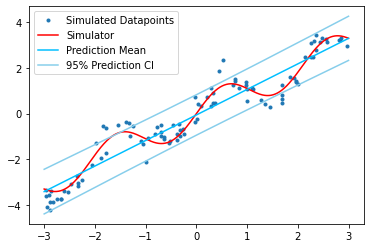

In [7]:
## testing the trained BLR 
## NOTE: with this code you can test your above implementation. 
# We calculate the true values of x_plot
x_plot = torch.linspace(-3., 3., 1000)
y_plot = x_plot + 0.7 * torch.sin(3 * x_plot)

# One benefit of being a Bayesian is that you can capture the predictive uncertainty: 
# Use the stochastic forward passing during prediction, and calculate the sample mean and 
# sample standard deviation of predictions for different sets of weights.

iteration = 100;
x_pred = []
for i in range(iteration):
    stochastic_flag = True
    x_pred.append(BLR(x_plot.view(-1,1), stochastic_flag)[0].view(-1).tolist())
x_pred = np.array(x_pred)

# Calculate the mean and standard deviation of prediction according to the samples
x_pred_mean = np.mean(x_pred, axis = 0)
x_pred_std = np.std(x_pred, axis = 0)

fig, ax = plt.subplots()
ax.plot(x_train, y_train, '.')
ax.plot(x_plot, y_plot, '-', color='red')

# Draw the mean of the prediction and also corresponding 95% crediable intervals.
ax.plot(x_plot, x_pred_mean, '-', color = 'deepskyblue')
ax.plot(x_plot, x_pred_mean - 2 * (x_pred_std+sigma_l), '-', color = 'skyblue')
ax.plot(x_plot, x_pred_mean + 2 * (x_pred_std+sigma_l), '-', color = 'skyblue')

ax.legend(('Simulated Datapoints','Simulator', 'Prediction Mean', '95% Prediction CI'))

# We can see that Bayesian linear regression cannot fit the data perfectly, because the simulator 
# that generates the data is nonlinear. However, the 95% crediable interval covers the true target 
# nearly all the time (95%), which means we can still know the possible interval of the target 
# even the model is misspecified.